## Import Req'd Libraries

In [1]:
import pandas as pd
import os
import seaborn as sns

## Functions for Getting File Names & Saving csv

In [10]:
#Getting all the file_names in a given directory
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)

#Saving the file
def save_file(root, name_of_file,my_dataframe):
    #Test if save directory exists
    try:
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file)
    #Otherwise make the directory and then save
    except:
        os.mkdir(root+'processed_data')
        my_dataframe.to_csv('processed_data/'+ name_of_file)


## Functions for Removing Missing Data and Outliers

In [3]:
#Function to remove missing data
def missing_data(my_dataframe):
    #computing number of total rows
    total_rows = my_dataframe.shape[0]
    #Dropping rows if empty cells are present in any of the given rows
    my_dataframe = my_dataframe.dropna(subset = ['id','last_scraped', 'host_is_superhost', 
                            'neighbourhood_cleansed', 'property_type',
                           'room_type','accommodates','bathrooms',
                           'bedrooms','beds','amenities', 'price',
                           'minimum_nights','maximum_nights',
                            'instant_bookable','cancellation_policy'])
    #Computing number of rows left after removing rows for error checking
    total_rows_after = my_dataframe.shape[0]
    
    #Printing
    print('total rows before missing data removal:', total_rows)
    print('total rows after missing data removal:', total_rows_after)
    
    return my_dataframe


def remove_outlier(my_dataframe):
    
    #Plotting a box and whisker plot for data visualization
    sns.boxplot(x=my_dataframe['price'])
    #Computing the quantiles of the box and whisker plot
    quantiles = my_dataframe['price'].quantile([0.0001, 0.01,0.25,0.5,0.75,0.95,0.99])
    
    #computing number of total rows prior to removing outliers
    total_rows = my_dataframe.shape[0]
    print('Number of rows before outlier removal',total_rows)
    
    #Adjusting data based on quantile information
    my_new_dataframe = my_dataframe[(my_dataframe['price'] < quantiles.ix[0.99]) & (my_dataframe['price'] > quantiles.ix[0.01])]
    quantiles = my_new_dataframe['price'].quantile([0.0001, 0.01,0.25,0.5,0.75,0.95,0.99])
    
    #computing new number of total rows
    total_rows = my_new_dataframe.shape[0]
    
    print('Number of rows after outlier removal',total_rows)

    return my_new_dataframe

## Functions for Mapping Categorical Data

In [4]:
# Map neighbourhood names to modified MLS district codes
def map_neighbourhoods(data, n_data):
    
    district = dict(zip(n_data["neighbourhood"].tolist(), n_data["district"].tolist()))
    district_group = dict(zip(n_data["neighbourhood"].tolist(), n_data["district_group"].tolist()))
    district_number = dict(zip(n_data["neighbourhood"].tolist(), n_data["district_number"].tolist()))

    data["district"] = data["neighbourhood_cleansed"].map(district)
    data["district_group"] = data["neighbourhood_cleansed"].map(district_group)
    data["district_number"] = data["neighbourhood_cleansed"].map(district_number)
    data["district"]
    return data

# Convert categorical data (e.g. host_is_superhost) into numerical codes
def cat_to_code(data, root, categories):
    category_codes = {}
    
    for i in categories:
        name = data[i].name
        category_codes[name] = data[i].astype("category").cat.categories # save list of categories
        data[name+"_codes"] = data[i].astype("category").cat.codes # convert to code
    
    for i in category_codes:
        df = pd.DataFrame()
        df[i] = category_codes[i]
        df.to_csv(root+r"category_codes/"+i+".csv")
    
    return data




# Filter out categories with a small percentage (<5% of data)
def filter_categorical(data, properties, can_policy):
    num_samples = data.shape[0]
    data = data[data.property_type.isin(properties)]
    num_samples2 = data.shape[0]
    data = data[data.cancellation_policy.isin(can_policy)]
    num_samples3 = data.shape[0]
    removed = {"properties": num_samples-num_samples2,
               "can_policy": num_samples2-num_samples3}
    print("Number removed:")
    print(removed)
    return data


/Users/BrianLam/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Start # of Rows: 21617
total rows before missing data removal: 21617
total rows after missing data removal: 21580
Number of rows before outlier removal 21580
Number of rows after outlier removal 21113


/Users/BrianLam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Number removed:
{'properties': 1122, 'can_policy': 67}
End # of Rows: 19924


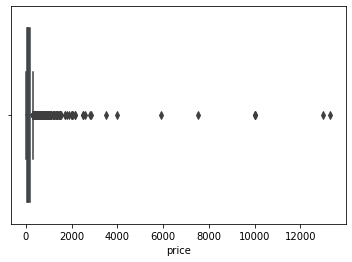

In [13]:
# get list of filenames
root = '../'

# Categories to convert to code
categories = ["host_is_superhost", "property_type", "room_type", "instant_bookable", "cancellation_policy"]

#Properties and cancellation policies to filter
properties = ["Apartment", "Condominium", "House", "Townhouse", "Guest suite", "Bungalow"]
can_policy = ["flexible", "moderate", "strict_14_with_grace_period"]

#mapping for neighbourhoods
n_data = pd.read_csv(root+'category_codes/neighbourhoods.csv')

#obtain list of files
name = get_file_names(root+'full_dataset')

for i in name:
    df = pd.read_csv(root+'full_dataset/'+i)
    print("Start # of Rows:", len(df))
    df["price"] = df["price"].apply(lambda x: x.replace('$','').replace(',', '').replace('.00', '')).astype("int")
    
    df = missing_data(df)
    df = remove_outlier(df)
    df = map_neighbourhoods(df, n_data)
    df = cat_to_code(df, root, categories)
    df = filter_categorical(df, properties, can_policy)
    print("End # of Rows:", len(df))
    print("Total # of Rows Removed")
    save_file(root, i, df)
    break
    
#save_file(name[1],df)
#df = missing_data(df)
#df = remove_outlier(df)


['18_04_09_listings.csv',
 '18_05_11_listings.csv',
 '18_07_06_listings.csv',
 '18_08_08_listings.csv',
 '18_09_08_listings.csv',
 '18_10_06_listings.csv',
 '18_11_04_listings.csv',
 '18_12_06_listings.csv',
 '19_01_13_listings.csv',
 '19_02_04_listings.csv',
 '19_03_07_listings.csv',
 '19_04_08_listings.csv',
 '19_05_06_listings.csv',
 '19_06_04_listings.csv',
 '19_07_08_listings.csv',
 '19_08_08_listings.csv']